In [2]:
import os, sys, numpy, pyRofex
from configparser import ConfigParser
from IPython.display import display
from matplotlib.pyplot import figure, subplots, style
from pandas import Series, DataFrame, Timestamp, Timedelta
from pandas import to_datetime, date_range, merge, concat
from pandas import Index, MultiIndex, DatetimeIndex
from mplfinance.plotting import plot
style.use("dark_background")

creds = ConfigParser()
creds.read("../auth/credentials.ini")
pyRofex.initialize(**creds["REMARKET"],
    environment = pyRofex.Environment.REMARKET)

Next: (1) Play models during live market. (2) Research, write & test \"Alma\" strategy. (3) Reformulate \"Interface._run_strategies\" to speed up loop. (4) Write \"main.py\". (5) Test live again and keep running during whole afternoon. (6) Write \"README.md\". (7) [optional] Move data templates to databases. (8) Deliver and exhibit

In [69]:
funcs = Series(pyRofex.__dir__())
funcs.loc[~ funcs.str.startswith("_") & funcs.str.islower()].to_list()

# get_market_data
# init_websocket_connection
# close_websocket_connection

# market_data_subscription
# add_websocket_market_data_handler
# remove_websocket_market_data_handler

# order_report_subscription
# add_websocket_order_report_handler
# remove_websocket_order_report_handler

# add_websocket_error_handler
# remove_websocket_error_handler

# send_order_via_websocket
# cancel_order_via_websocket

['clients',
 'components',
 'service',
 'initialize',
 'set_default_environment',
 'init_websocket_connection',
 'close_websocket_connection',
 'market_data_subscription',
 'order_report_subscription',
 'add_websocket_market_data_handler',
 'remove_websocket_market_data_handler',
 'add_websocket_order_report_handler',
 'remove_websocket_order_report_handler',
 'add_websocket_error_handler',
 'remove_websocket_error_handler',
 'set_websocket_exception_handler',
 'send_order_via_websocket',
 'cancel_order_via_websocket',
 'get_segments',
 'get_instruments',
 'get_all_instruments',
 'get_detailed_instruments',
 'get_instrument_details',
 'get_market_data',
 'get_trade_history',
 'send_order',
 'cancel_order',
 'get_order_status',
 'get_all_orders_status',
 'get_account_position',
 'get_detailed_position',
 'get_account_report']

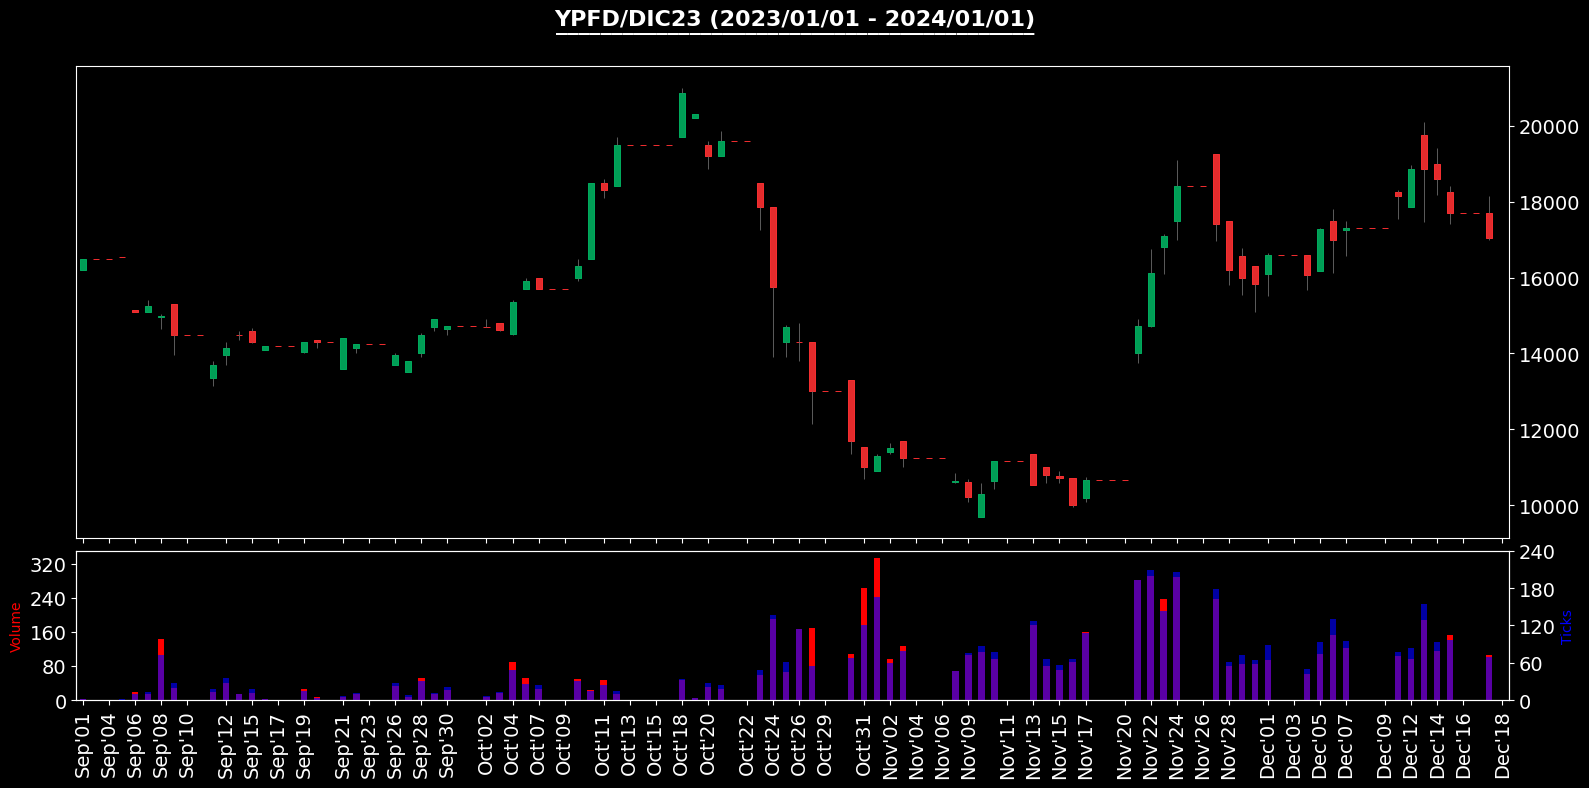

In [4]:
args = dict(
    ticker = "YPFD/DIC23",
    start_date = "2023-01-01",
    end_date = "2024-01-01",
)
hist = pyRofex.get_trade_history(**args)
hist = DataFrame(hist["trades"]).set_index("datetime")
hist.index = to_datetime(hist.index)
hist = hist[["symbol", "size", "price"]]
since, until = hist.index[[0, -1]]

ohlc = hist["price"].resample("D").ohlc()
volume = hist["size"].resample("D").sum()
ticks = hist["size"].resample("D").count()
ohlc["close"] = ohlc["close"].ffill()
ohlc = ohlc.bfill(axis = "columns")

fig = figure(figsize = (16, 8))
axp = fig.add_subplot(4, 1, (1, 3))
axs = fig.add_subplot(4, 1, (4, 4), sharex = axp)
axt = axs.twinx()
axp.tick_params(labelsize = 14)
axs.tick_params(labelsize = 14), axs.set_ylabel("Volume", color = "red")
axt.tick_params(labelsize = 14), axt.set_ylabel("Ticks", color = "blue")
plot(ax = axp, data = ohlc, type = "candle", style = "yahoo")
volume.plot.bar(ax = axs, color = "red", alpha = 1.00)
ticks.plot.bar(ax = axt, color = "blue", alpha = 0.65)

xticks = numpy.linspace(0, len(ohlc), 50).astype(int)
xlabels = date_range(since, until, periods = len(xticks)).strftime("%b'%d")
axs.set_xticks(xticks), axs.set_xticklabels(xlabels, rotation = 90)
axs.set_xlim(- 0.5, len(ohlc) + 0.5)
axs.set_xlabel(""); axp.set_ylabel("")

vmax = volume.max()
vmult = 10.0 ** int(numpy.log10(vmax))
vmax = (int(vmax / vmult) + 1) * vmult
vticks = numpy.arange(0, vmax, vmax // 5)
axs.set_yticks(vticks)
tmax = ticks.max()
tmult = 10.0 ** int(numpy.log10(tmax))
tmax = (int(tmax / tmult) + 1) * tmult
tticks = numpy.arange(0, tmax, tmax // 5)
axt.set_yticks(tticks)

args["end_date"] = args["end_date"].replace("-", "/")
args["start_date"] = args["start_date"].replace("-", "/")
title = "{ticker} ({start_date} - {end_date})".format(**args)
args["end_date"] = args["end_date"].replace("/", "")
args["start_date"] = args["start_date"].replace("/", "")
filename = "{ticker}_{start_date}_{end_date}.jpg".format(**args)
title = title + "\n" + "‾" * int(len(title) * 1.2)
filename = filename.replace(" ", "").replace("/", "-")
fig.suptitle(title, fontsize = 16, fontweight = "bold")
fig.set_tight_layout({"h_pad": 0.01, "w_pad": 0.05})
fig.savefig(filename, dpi = 200)